# Supplementary Figure S1

### Setups

In [1]:
library(TCGAbiolinks)
library(dplyr)
library(DT)
library(ggplot2)
library(patchwork)
library(ggpubr)
library(rstatix)
library(ggsci)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:
tcga.colors<-c("#EF9A9A","#F8BBD0","#CE93D8","#B39DDB","#9FA8DA",
               "#90CAF9","#81D4FA","#80DEEA","#80CBC4","#A5D6A7",
               "#C5E1A5","#E6EE9C","#FFF59D","#FFE082","#BCAAA4",
               "#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5",
               "#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
               "#8BC34A","#CDDC39","#FFC107","#FF9800","#795548",
               "#B71C1C")

### Load data

In [3]:
load("../input/tcga.metadata.RData")
names(tcga.colors)<-unique(metadata$cancer)

## Distributions of impurity across cancers

In [4]:
cord<-metadata %>% 
        filter(condition=="tumor") %>% 
        group_by(cancer) %>% 
        summarize(median_imp=median(impurity,na.rm=T),
                  mean_imp=mean(impurity,na.rm=T),
                  var_imp=var(impurity),
                  sd_imp=sd(impurity)) %>% 
        arrange(desc(median_imp))
colors.cord<-tcga.colors[cord$cancer]

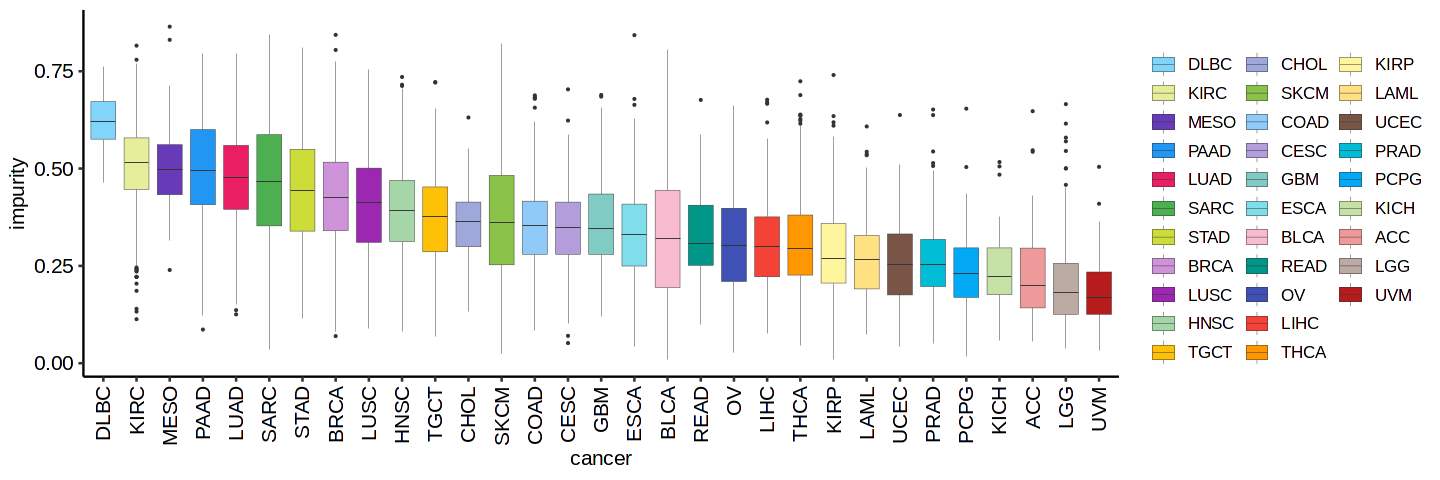

In [5]:
options(repr.plot.width=12,repr.plot.height=4)
p<-metadata %>%
    filter(condition=="tumor") %>%
    mutate(cancer=factor(cancer,levels=cord$cancer))%>%
    ggplot(.,aes(x=cancer,y=impurity,fill=cancer))+
        geom_boxplot(linewidth=0.1,outlier.size = 0.1)+
        theme_pubr()+
        theme(legend.position="right",
              axis.text.x=element_text(angle=90,vjust=0.5,hjust=1))+
        scale_fill_manual(values=colors.cord)+
        guides(fill=guide_legend(ncol=3))+
        labs(fill="",xlab="")
p
ggsave(p,filename="../output/impurity/tumorImpurity_allCancers.pdf",device="pdf",width = 12,height = 4,units = "in")
ggsave(p,filename="../output/impurity/tumorImpurity_allCancers.png",device="png",width = 12,height = 4,units = "in",dpi=1000)

## Comparison of tumor purities obtained from different sources

In [6]:
cancers <- read.table("../input/cancers_valid.tsv") %>%
           rename("cancer"="V1") %>%
           mutate(project=paste("TCGA-",cancer,sep=""))

In [7]:
# Tumor purity from TCGAbiolinks
biol.purity<-TCGAbiolinks::Tumor.purity %>%
            mutate(CPE=as.numeric(sub(",",".",as.character(CPE))),
                   ESTIMATEPurity=as.numeric(sub(",",".",as.character(ESTIMATE))),
                   ABSOLUTE=as.numeric(sub(",",".",as.character(ABSOLUTE))),
                   LUMP=as.numeric(sub(",",".",as.character(LUMP))),
                   IHC=as.numeric(sub(",",".",as.character(IHC))),
                   patient_id=sub("-0\\d+[A]","",as.character(Sample.ID)),
                   project=paste0("TCGA-",Cancer.type)) %>%
            rename("submitter_id"="Sample.ID",
                  "cancer"="Cancer.type") %>%
            mutate(ESTIMATEScore=-1*4121.49 + 6812.53*acos(ESTIMATEPurity)) %>%
            select(-ESTIMATE) %>%
            filter(!is.na(ESTIMATEPurity)) %>%
            select(cancer,submitter_id,ABSOLUTE,ESTIMATEPurity,ESTIMATEScore) %>%
            rename("ESTIMATEPurity.biol"="ESTIMATEPurity",
                   "ESTIMATEScore.biol"="ESTIMATEScore")
dim(biol.purity)

[1] 7737    5

In [8]:
# Tumor purity from ESTIMATE (original formula)
est.purity<-lapply(cancers$cancer,function(cancer){
    est<-data.table::fread(paste("../input/ESTIMATE/",cancer,"_purity_illumina.tsv",sep=""),data.table=F,drop = 2)[c(-1,-2),] %>% t()
    colnames(est)<-est[1,]
    est<-est[-1,] %>%
         as.data.frame() %>%
         rename("submitter_id"="NAME")%>%
         mutate(submitter_id=gsub("\\.","-",submitter_id),
                cancer = cancer) %>%
         mutate(across(StromalScore:ESTIMATEScore,as.numeric),
                ESTIMATEPurity.orig = cos(0.6049872018+0.0001467884*ESTIMATEScore)) %>%
         rename("ESTIMATEScore.orig"="ESTIMATEScore")
    return(est)
    }) %>% 
    do.call(rbind,.) %>%
    filter(!is.na(ESTIMATEScore.orig))
dim(est.purity)

[1] 10247     6

In [9]:
# Combine tables
purity.full<-full_join(biol.purity,est.purity,by = c("cancer", "submitter_id"))  
dim(purity.full)

[1] 10420     9

In [10]:
# Number of samples missing in TCGAbiolinks 
sum(!est.purity$submitter_id%in%biol.purity$submitter_id)

[1] 2683

In [11]:
# Number of samples with purity from ABSOLUTE 
sum(!is.na(purity.full$ABSOLUTE))

[1] 3143

### ESTIMATE scores vs ABSOLUTE purities

Warning message:
“Removed 85 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 85 rows containing missing values (`geom_point()`).”


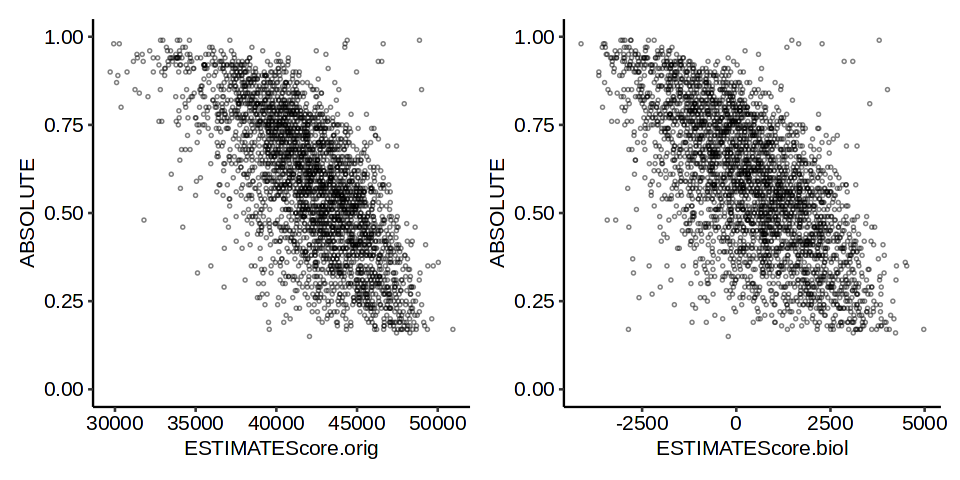

In [12]:
options(repr.plot.height=4,repr.plot.width=8)
p1<-purity.full %>%
    filter(!is.na(ABSOLUTE))%>%
    ggplot(.,aes(x=ESTIMATEScore.orig,y=ABSOLUTE))+
        geom_abline(intercept = 0,linewidth=0.5,linetype="dashed",color="grey")+
        geom_point(size=0.5,pch=21,alpha=0.5)+
        theme_pubr()+
        labs(xlab="")+
        ylim(c(0,1))
p2<-purity.full %>%
    filter(!is.na(ABSOLUTE))%>%
    ggplot(.,aes(x=ESTIMATEScore.biol,y=ABSOLUTE))+
        geom_point(size=0.5,pch=21,alpha=0.5)+
        theme_pubr()+
        ylim(c(0,1))

ggsave(p1,filename="../output/impurity/ABS_vs_Escore.manualOriginal.pdf",device="pdf",width = 4,height = 4,units = "in")
ggsave(p2,filename="../output/impurity/ABS_vs_Escore.TCGAbiolinks.pdf",device="pdf",width = 4,height = 4,units = "in")
p1+p2

### ESTIMATE purities vs ABSOLUTE purities

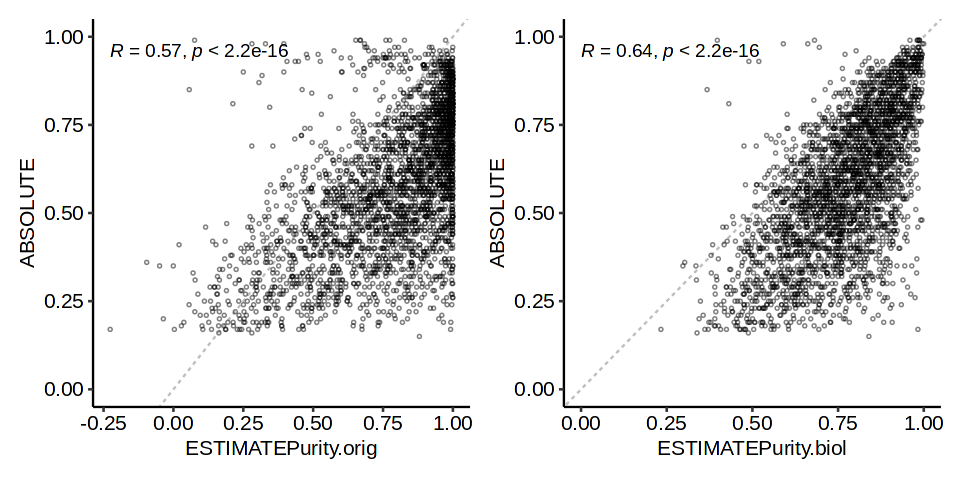

In [13]:
options(repr.plot.height=4,repr.plot.width=8)

p3<-purity.full %>%
    na.omit() %>%
    ggplot(.,aes(x=ESTIMATEPurity.orig,y=ABSOLUTE))+
        geom_abline(intercept = 0,linewidth=0.5,linetype="dashed",color="grey")+
        geom_point(size=0.5,pch=21,alpha=0.5)+
        theme_pubr()+  
        ylim(c(0,1))+
        stat_cor(na.rm = T)

p4<-purity.full %>%
    na.omit() %>%
    ggplot(.,aes(x=ESTIMATEPurity.biol,y=ABSOLUTE))+
        geom_abline(intercept = 0,linewidth=0.5,linetype="dashed",color="grey")+
        geom_point(size=0.5,pch=21,alpha=0.5)+
        theme_pubr()+    
        ylim(c(0,1))+
        xlim(c(0,1))+
        stat_cor(na.rm=T)

ggsave(p3,filename="../output/impurity/ABS_vs_Epurity.manualOriginal.pdf",device="pdf",width = 4,height = 4,units = "in")
ggsave(p4,filename="../output/impurity/ABS_vs_Epurity.TCGAbiolinks.pdf",device="pdf",width = 4,height = 4,units = "in")
p3+p4

### ESTIMATE score vs purity from running ESTIMATE or from TCGAbiolinks

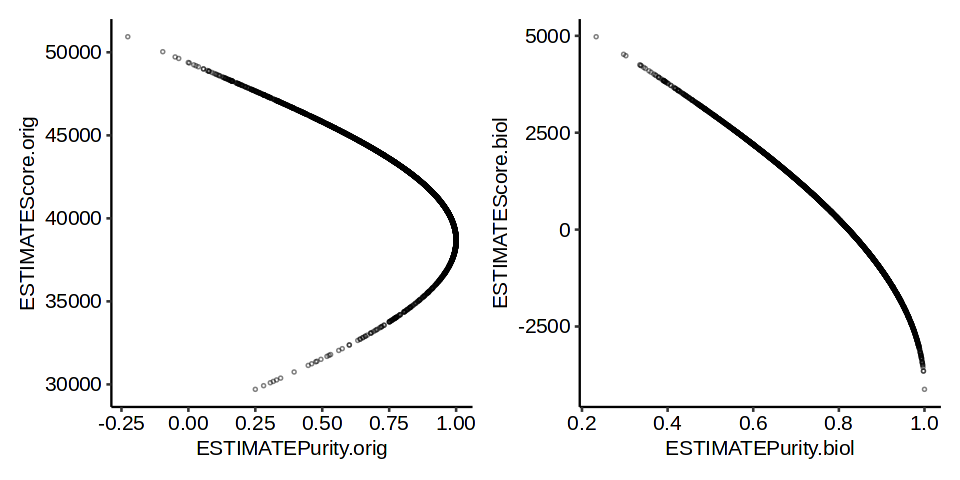

In [14]:
options(repr.plot.width=8,repr.plot.height=4)
p1<-purity.full %>%
    na.omit() %>%
    ggplot(.,aes(x=ESTIMATEPurity.orig,y=ESTIMATEScore.orig))+
    geom_point(size=0.5,pch=21,alpha=0.5)+
    theme_pubr()

p2<-purity.full %>%
    na.omit() %>%
    ggplot(.,aes(x=ESTIMATEPurity.biol,y=ESTIMATEScore.biol))+
    geom_point(size=0.5,pch=21,alpha=0.5)+
    theme_pubr()

ggsave(p2,filename="../output/impurity/TCGAbiolinks_EPurity_vs_EScore.pdf",device="pdf",width = 4,height = 4,units = "in")
ggsave(p1,filename="../output/impurity/manualOriginal_EPurity_vs_EScore.pdf",device="pdf",width = 4,height = 4,units = "in")
p1+p2

### ESTIMATE purities or scores from running ESTIMATE vs TCGAbiolinks

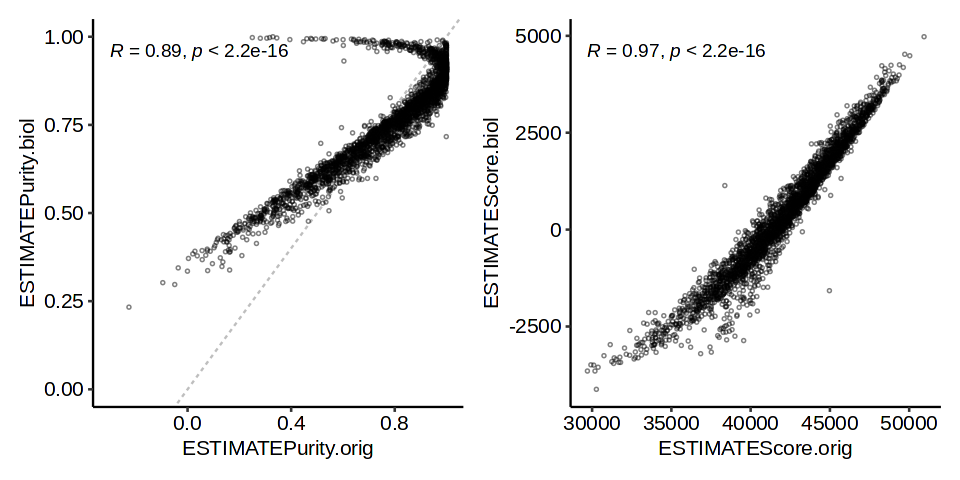

In [15]:
options(repr.plot.height=4,repr.plot.widht=8)
p1<-purity.full %>%
    na.omit() %>%
    ggplot(.,aes(x=ESTIMATEPurity.orig,y=ESTIMATEPurity.biol))+
        geom_abline(intercept = 0,linewidth=0.5,linetype="dashed",color="grey")+
        geom_point(size=0.5,pch=21,alpha=0.5)+
        theme_pubr()+
        ylim(c(0,1))+
        xlim(c(-0.3,1))+
        stat_cor()

p2<-purity.full %>%
    na.omit() %>%
    ggplot(.,aes(x=ESTIMATEScore.orig,y=ESTIMATEScore.biol))+
        geom_abline(intercept = 0,linewidth=0.5,linetype="dashed",color="grey")+
        geom_point(size=0.5,pch=21,alpha=0.5)+
        theme_pubr()+
        stat_cor()

ggsave(p1,filename="../output/impurity/EPurity_TCGAbiolinks_vs_manualOriginal.pdf",device="pdf",width = 4,height = 4,units = "in")
ggsave(p2,filename="../output/impurity/EScore_TCGAbiolinks_vs_manualOriginal.pdf",device="pdf",width = 4,height = 4,units = "in")

p1+p2